In [1]:
#Importing the necessary libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

<h4>Load Data & Preprocessing</h4>

In [2]:
# Load the dataset
df = pd.read_csv("/Users/nbakhati/Library/CloudStorage/OneDrive-UniversityofNebraskaatOmaha/Fraud Detection/Code/new_fraud_dataset.csv") 

In [3]:
# Drop transaction identifiers and datetime
df.drop(columns=['TransactionID', 'TransactionDT'], inplace=True, errors='ignore')

In [4]:
# Encode all categorical (object type) columns using LabelEncoder. Necessary for models like XGBoost and RandomForest which don't handle strings.
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

<h4>APPLY MINMAX SCALER</h4>

In [5]:
# Making a copy of the original dataframe to preserve raw values
df_scaled = df.copy()

# Select numeric columns for scaling, excluding the target 'isFraud'
numeric_cols = df_scaled.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop(['isFraud'])

In [6]:
# Apply MinMax scaling to normalize values between 0 and 1
scaler = MinMaxScaler()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

In [7]:
# Separate features and target
X = df_scaled.drop("isFraud", axis=1)
y = df_scaled["isFraud"]

We are dealing with class imbalance dataset so here we will downsample the non-fraud class to match the fraud class. 

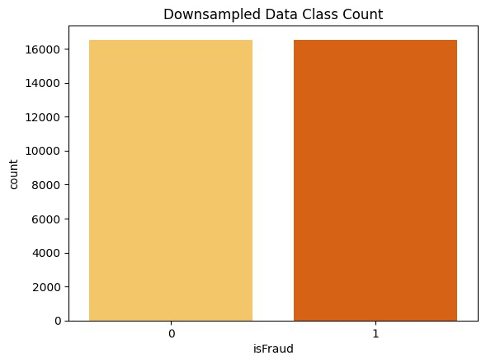

<h4>TRAIN-TEST SPLIT</h4>

In [8]:
# Stratified split to maintain fraud ratio in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)


<h4>Ensemble Undersampling Loop (B=15)</h4>

In [9]:
# Split training data into fraud and non-fraud subsets
fraud = X_train[y_train == 1]
nonfraud = X_train[y_train == 0]
y_fraud = y_train[y_train == 1]
y_nonfraud = y_train[y_train == 0]

In [10]:
# Initialize storage for probability votes from models
B = 15
vote_probas = {'XGBoost': [], 'RandomForest': [], 'Logistic': [], 'CatBoost': []}
xgb_models, rf_models, cat_models, log_models = [], [], [], []

for i in range(B):
    # Undersample majority (non-fraud) class with replacement
    nonfraud_sample = nonfraud.sample(n=len(fraud), replace=True, random_state=i)
    y_nonfraud_sample = y_nonfraud.loc[nonfraud_sample.index]
    
    # Combine undersampled non-fraud and fraud for balanced training
    X_bal = pd.concat([fraud, nonfraud_sample])
    y_bal = pd.concat([y_fraud, y_nonfraud_sample])
    
    # Shuffle the balanced training data
    shuffler = np.random.permutation(len(X_bal))
    X_bal = X_bal.iloc[shuffler]
    y_bal = y_bal.iloc[shuffler]

    # Train and store predictions from each model
    rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=i)
    rf_model.fit(X_bal, y_bal)
    vote_probas['RandomForest'].append(rf_model.predict_proba(X_test)[:, 1])
    rf_models.append(rf_model)

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=i)
    xgb_model.fit(X_bal, y_bal)
    vote_probas['XGBoost'].append(xgb_model.predict_proba(X_test)[:, 1])
    xgb_models.append(xgb_model)

    log_model = LogisticRegression(max_iter=1000, solver='lbfgs', penalty='l2', random_state=i)
    log_model.fit(X_bal, y_bal)
    vote_probas['Logistic'].append(log_model.predict_proba(X_test)[:, 1])
    log_models.append(log_model)

    cat_model = CatBoostClassifier(verbose=0, random_state=i)
    cat_model.fit(X_bal, y_bal)
    vote_probas['CatBoost'].append(cat_model.predict_proba(X_test)[:, 1])
    cat_models.append(cat_model)

/Users/nbakhati/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:16:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nbakhati/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:17:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nbakhati/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:17:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/nbakhati/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:17:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

Each iteration randomly resamples non-fraud cases to match fraud cases → balanced dataset → better sensitivity to frauds. Train 4 different models per iteration and store their test set probabilities for ensembling.

<h4>METRICS + THRESHOLD TUNING</h4>

In [11]:
# Function to compute classification metrics
def get_metrics(y_true, y_pred, y_probs, model_name):
    return {
        "Model": model_name,
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_probs)
    }


Goal:

- Tune threshold per model to maximize F1 score (balances precision and recall).
- Compute and store evaluation metrics: Precision, Recall, F1 Score, ROC AUC, and the chosen Threshold.

In [12]:
# Store evaluation results and optimal thresholds
results = []
best_thresholds = {}

for model in vote_probas.keys():
    avg_probs = np.mean(vote_probas[model], axis=0)
    precisions, recalls, thresholds = precision_recall_curve(y_test, avg_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_thresholds[model] = best_threshold

    y_pred = (avg_probs > best_threshold).astype(int)
    metrics = get_metrics(y_test, y_pred, avg_probs, model)
    metrics['Best Threshold'] = round(best_threshold, 4)
    results.append(metrics)

In [14]:
# Display performance metrics
comparison_df = pd.DataFrame(results)
print("\nModel Performance (Ensemble Undersampling B=15):")
print(comparison_df)


Model Performance (Ensemble Undersampling B=15):
          Model  Precision    Recall  F1 Score   ROC AUC  Best Threshold
0       XGBoost   0.714160  0.588193  0.645084  0.946770          0.8695
1  RandomForest   0.688404  0.564481  0.620314  0.932036          0.8053
2      Logistic   0.343889  0.299540  0.320186  0.827581          0.8193
3      CatBoost   0.724500  0.534479  0.615149  0.939622          0.8766


Result Interpretation: 

- XGBoost delivered the best overall performance, with the highest F1 Score (0.645) and ROC AUC (0.947), indicating strong balance between precision and recall.
- CatBoost closely followed, with the highest Precision (0.725), meaning it was best at minimizing false positives, though its recall was slightly lower than XGBoost.
- Random Forest achieved moderate performance across all metrics, showing solid but not leading effectiveness.
- Logistic Regression underperformed significantly, with much lower precision, recall, and F1 Score suggesting it may be too simple for the complexity of this fraud detection task.

<h4>CONFUSION MATRIX FOR EACH MODEL</h4>

Visually inspect each model’s performance to understand false positives/negatives tradeoffs.

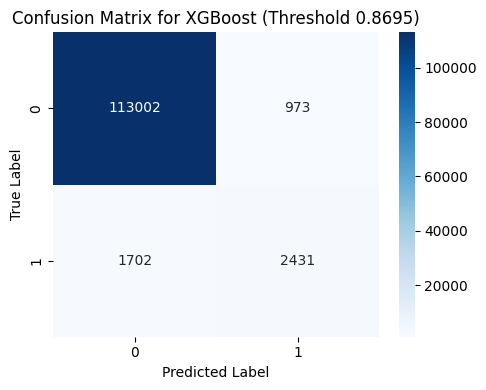

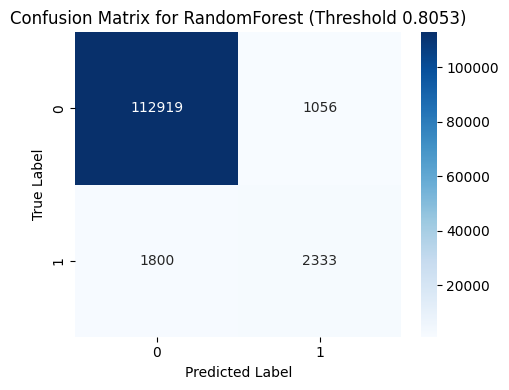

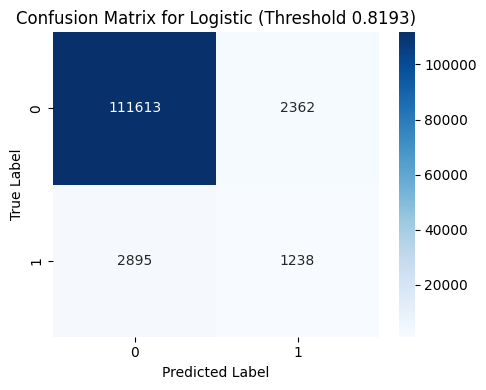

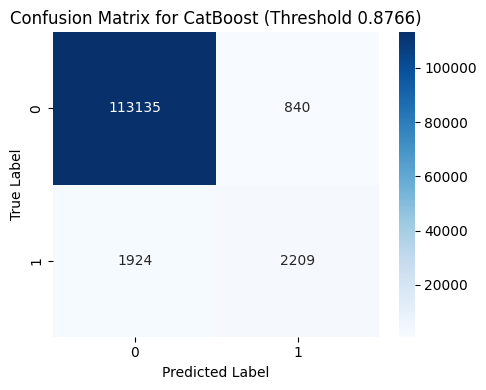

In [15]:
# Plot confusion matrix using best threshold for each model
for model in vote_probas.keys():
    avg_probs = np.mean(vote_probas[model], axis=0)
    best_threshold = best_thresholds[model]
    y_pred = (avg_probs > best_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model} (Threshold {best_threshold:.4f})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

Result Interpretation: Among the four models tested using ensemble undersampling (B=15), XGBoost delivered the most balanced performance, achieving the highest number of correctly identified fraud cases (2,431 true positives) while maintaining a low false positive rate (973). This makes it the most reliable model when both fraud detection and minimizing disruptions to legitimate users are important. CatBoost stood out with the fewest false positives (840), indicating it is the most conservative model—ideal in scenarios where false alarms are costly—but it also missed more fraud cases (1,924 false negatives) compared to XGBoost. Random Forest provided moderately strong results, trailing slightly behind XGBoost in both fraud detection and false positive control. In contrast, Logistic Regression significantly underperformed, misclassifying the most frauds (2,895 false negatives) and generating the highest number of false positives (2,362), making it unsuitable for high-stakes fraud detection where class imbalance and nuanced patterns matter.

<h4>F1-SCORE VS THRESHOLD CURVE</h4>

Display how F1 score changes with different thresholds. The red dashed line helps identify the optimal cutoff value.

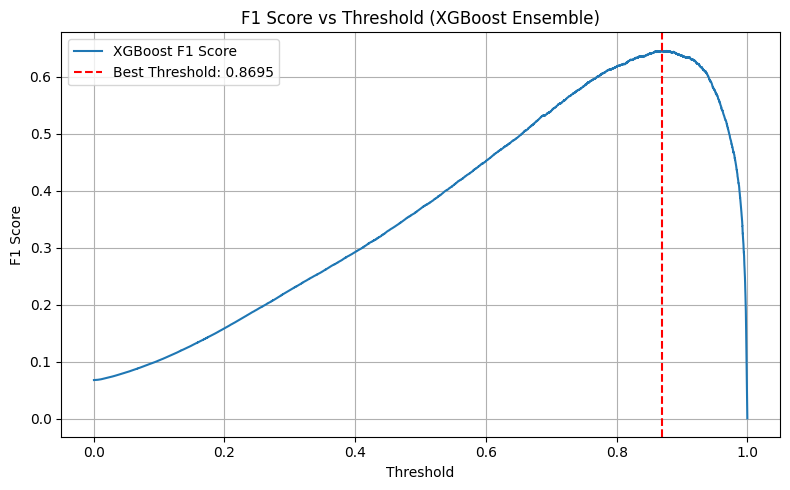

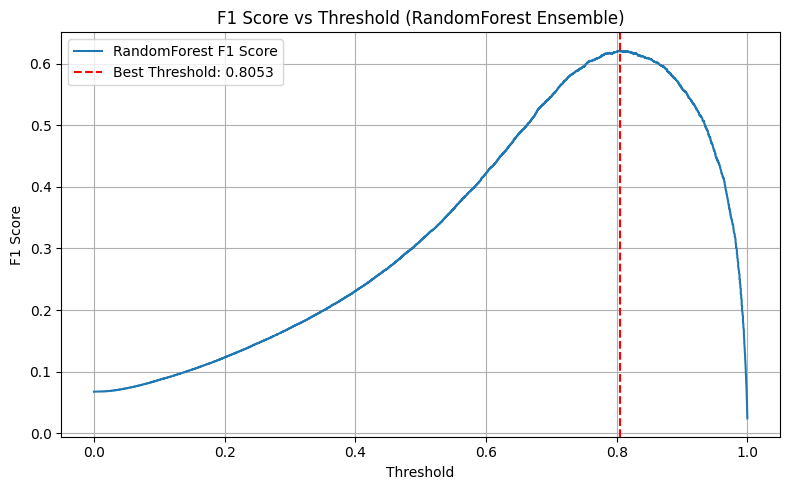

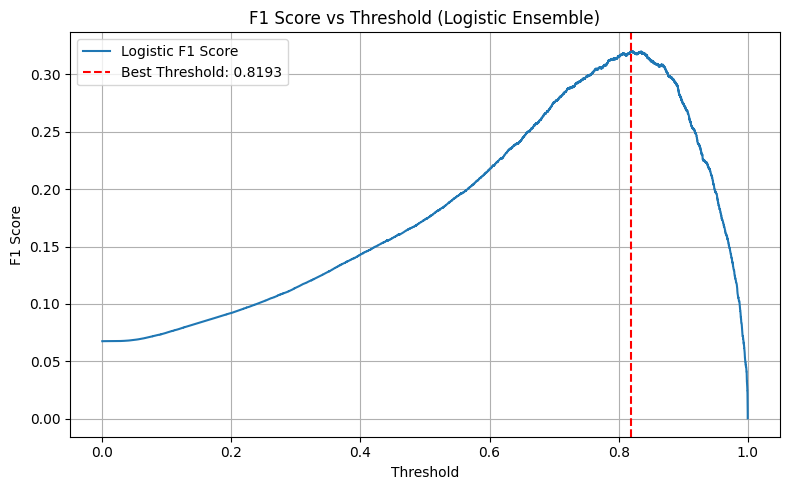

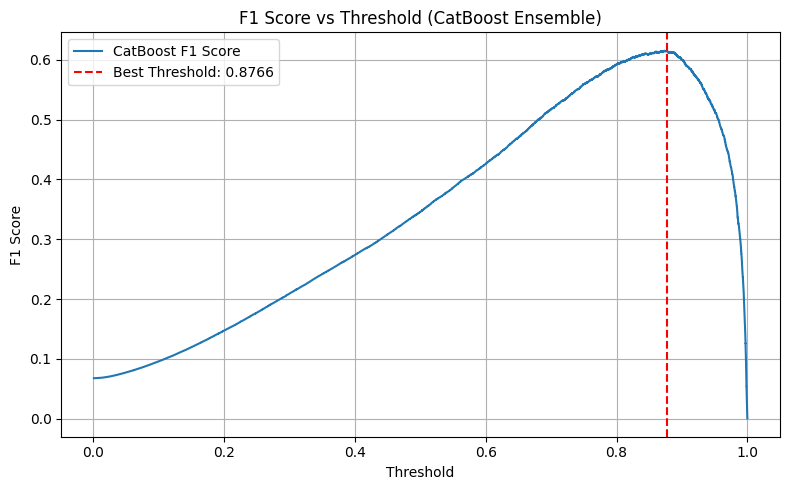

In [16]:
# Plot F1 Score vs Threshold to visualize optimal decision boundary
for model in vote_probas.keys():
    avg_probs = np.mean(vote_probas[model], axis=0)
    precisions, recalls, thresholds = precision_recall_curve(y_test, avg_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores[:-1], label=f"{model} F1 Score")
    plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold: {best_threshold:.4f}")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score vs Threshold ({model} Ensemble)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Result Interpreation: For XGBoost, the F1 score peaks around a threshold of 0.8695, showing a smooth and steep rise, indicating it benefits significantly from threshold tuning. This model achieves the best balance between precision and recall, making it highly reliable for fraud detection. Random Forest also shows a strong F1 score curve with its optimal threshold at 0.8053, but the overall peak is slightly lower than XGBoost’s, reflecting its slightly reduced capability to capture fraud cases as effectively. CatBoost demonstrates a similar curve to XGBoost with its best threshold at 0.8766, showing high performance with a conservative cutoff, which suits scenarios where false positives are particularly costly. On the other hand, Logistic Regression has a noticeably lower and flatter curve, peaking around 0.8193, indicating its limited ability to improve with threshold tuning and reinforcing its underperformance in this context.

<h4>Feature importance Functions</h4>

In [17]:
def average_feature_importances(models):
    importances = np.array([model.feature_importances_ for model in models])
    return np.mean(importances, axis=0)

def average_catboost_importances(models):
    importances = np.array([model.get_feature_importance() for model in models])
    return np.mean(importances, axis=0)

def plot_feature_importance(importances, feature_names, model_name, top_n=10, color='skyblue'):
    indices = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(8, 5))
    plt.barh(range(len(indices)), importances[indices], align='center', color=color)
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title(f"{model_name} - Top {top_n} Feature Importances")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

def average_logistic_coefficients(models):
    coefs = np.array([model.coef_[0] for model in models])
    return np.mean(np.abs(coefs), axis=0)

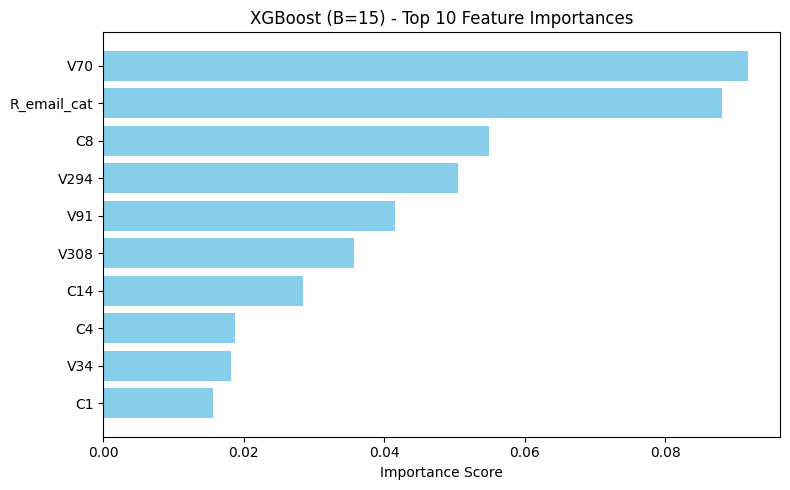

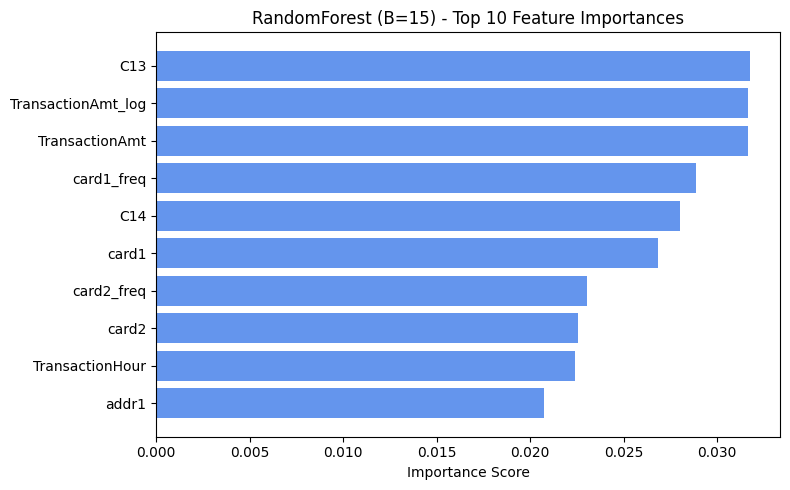

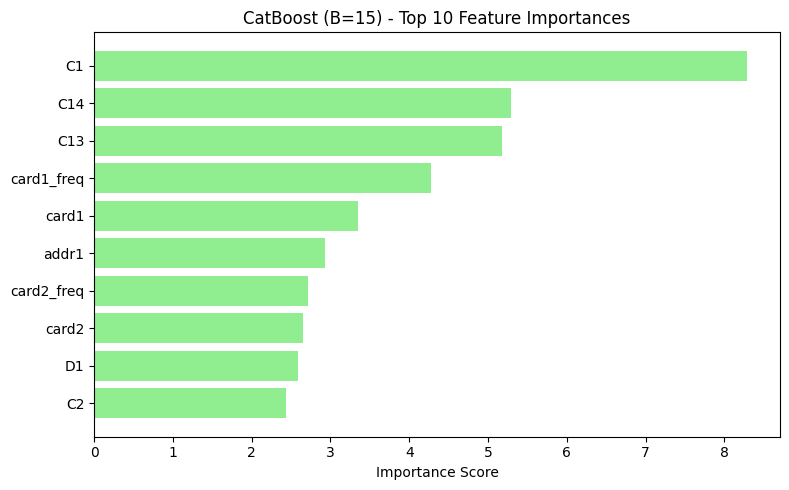

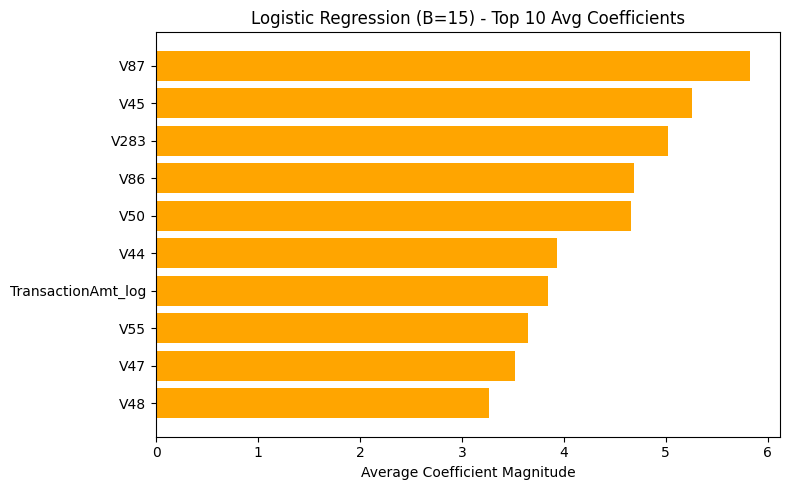

In [18]:
# PLOT FEATURE IMPORTANCES

xgb_importance_avg = average_feature_importances(xgb_models)
plot_feature_importance(xgb_importance_avg, X.columns, "XGBoost (B=15)", color='skyblue')

rf_importance_avg = average_feature_importances(rf_models)
plot_feature_importance(rf_importance_avg, X.columns, "RandomForest (B=15)", color='cornflowerblue')

cat_importance_avg = average_catboost_importances(cat_models)
plot_feature_importance(cat_importance_avg, X.columns, "CatBoost (B=15)", color='lightgreen')

log_coef_avg = average_logistic_coefficients(log_models)
top_n = 10
indices = np.argsort(log_coef_avg)[-top_n:]
plt.figure(figsize=(8, 5))
plt.barh(range(len(indices)), log_coef_avg[indices], align='center', color='orange')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title(f"Logistic Regression (B=15) - Top {top_n} Avg Coefficients")
plt.xlabel("Average Coefficient Magnitude")
plt.tight_layout()
plt.show()

Result Interpretation: 

- XGBoost found that features like V70 and R_email_cat were the strongest indicators of fraud. These may relate to unusual behavior patterns or rare email domains used by fraudsters. It also used other behavior and transaction-related features like C8 and V294.
- Random Forest focused more on the actual transaction amount (TransactionAmt and TransactionAmt_log) and how often specific card details appear (card1_freq, card2_freq). This means it detects fraud by noticing unusual spending amounts or rare card usage.
- CatBoost put a lot of weight on features like C1, C14, and C13, which are count-based features, often showing how many times something was seen before. It also used card and address features, meaning it looks for strange or rare combinations of card details and locations.
- Logistic Regression relied mostly on V series features like V87, V45, and V283, which are likely related to user behavior and device activity. It also used the log of the transaction amount. Since Logistic Regression is a simpler model, it mainly picks up on individual patterns rather than complex combinations.